# Test-time dropout script

The goal is to develop a function with a command line interface that takes a trained model with dropout and returns an ensemble prediction, so I imagine something like:

```
python create_dropout_ensemble.py --exp_id 44-resnet_deeper2 --members 100 ...
```

The script should return and save a xarray dataset just like `create_prediction` but with an added dimension `ens_member`.

You basically already did the work in the starter exercise I gave you. You can also check out my solution. Now it's just a matter of creating a convenient script. For examples of command line scripts I wrote, check out `src/extract_level.py` using `argparse` or `scripts/download_tigge.py` using Google's `fire`. Also, see whether your or my method of implementing the test-time dropout is more convenient. Whatever requires fewer changes to the rest of the code (probably yours).

As mentioned in the WeatherBench paper, testing is done using the years 2017 and 2018. This means the ensemble predictions also have to be created for these two years. The data can be downloaded here: https://mediatum.ub.tum.de/1524895. However, the files, which contain all years, are quite large, so you probably don't want to download it to your laptop. I uploaded just the last two years for each variable here: To come...

Next, you need a trained model. I number my experiments (see Dropbox document). You can find two different models in the link above. 

As mentioned in the Dropbox document, I would suggest developing the main function in the notebook. Once that works, you can create a CLI around it and save the script. 

Also, let's use `tensorflow>=2.0`.

#This notebook is just for testing. Script saved as create_dropout_ensemble.py

ToDo:
- make it work for all networks. #(Differences: custom_objects, -can be done with an if conditon on load_model(), #output_vars, test_years, lead_time?, anything else?
- load full data instead of batches. output for full size of X.
- pass optional arguments. like is_normalized, start_date, end_date, test_years
- what to do if output vars are different?? numpy-->xarray wont work
- solve eager_execution problem

In [1]:
# Here is a useful tip: Using autoreload allows you to make changes to an imported module
# which are then automatically updated in this notebook. This is how I start all my notebooks.
%load_ext autoreload
%autoreload 2 # Every two seconds

In [2]:
import fire
from fire import Fire
import xarray as xr
import numpy as np
from src.data_generator import *
from src.train import *
from src.networks import *
from src.utils import *
from tensorflow.keras import backend as K

In [ ]:
#Final Working Script
# exp_id_path='/home/garg/WeatherBench/nn_configs/B/63-resnet_d3_best.yml'
# model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
# datadir='/home/garg/data/WeatherBench/5.625deg'
# pred_save_dir='/home/garg/data/WeatherBench/predictions'

# !python create_dropout_ensemble.py 5 {exp_id_path} {datadir} {model_save_dir} {pred_save_dir}

In [ ]:
#Everything from below is just for practice. can ignore.

In [3]:
# You only need this if you are using a GPU
# os.environ["CUDA_VISIBLE_DEVICES"]=str(0)
# limit_mem()

In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14054787479720317766
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 15251105250194967598
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
tf.compat.v1.disable_eager_execution() #needed
tf.__version__

'2.1.0'

In [7]:
exp_id_path='/home/garg/WeatherBench/nn_configs/B/63-resnet_d3_best.yml'
!ls {exp_id_path}

/home/garg/WeatherBench/nn_configs/B/63-resnet_d3_best.yml


In [40]:
# exp_id_path='../nn_configs/B/53-unet_google_dropout_0.2_no_ss.yml'
# !ls {exp_id_path}

../nn_configs/B/53-unet_google_dropout_0.2_no_ss.yml


In [36]:
# exp_id_path='../nn_configs/B/28-unet_medium_bn_dropout_0.2.yml'
# !ls {exp_id_path}

../nn_configs/B/28-unet_medium_bn_dropout_0.2.yml


In [8]:
    args=load_args(exp_id_path)
    exp_id=args['exp_id']
    var_dict=args['var_dict']
    batch_size=args['batch_size']
    output_vars=args['output_vars']
    
    #Question: how to optionally  input data_subsample, norm_subsample, nt_in, dt_in, test_years?
    data_subsample=args['data_subsample']
    norm_subsample=args['norm_subsample']
    nt_in=args['nt_in']
    dt_in=args['dt_in']
    test_years=args['test_years']
    lead_time=args['lead_time']
    #changing paths
    model_save_dir='/home/garg/data/WeatherBench/predictions/saved_models'
    datadir='/home/garg/data/WeatherBench/5.625deg'

In [13]:
nt_in#Ques: difference b/w nt and nt_in

3

In [9]:
ds = xr.merge([xr.open_mfdataset(f'{datadir}/{var}/*.nc', combine='by_coords') for var in var_dict.keys()])
mean = xr.open_dataarray(f'{model_save_dir}/{exp_id}_mean.nc') 
std = xr.open_dataarray(f'{model_save_dir}/{exp_id}_std.nc')

In [10]:
#Ques:  shuffle should be false? since its testing
#Question: Should we input data_subsample, norm_subsample, nt_in, dt_in? 
#for instance, dt_in not always provided in config file. 'nt_in' is sometimes called 'nt' is it?
ds_test= ds.sel(time=slice(test_years[0],test_years[-1]))
dg_test = DataGenerator(ds_test, var_dict, lead_time, batch_size=batch_size, shuffle=False, load=True,
                 mean=mean, std=std, output_vars=output_vars, data_subsample=data_subsample, norm_subsample=1,
                 nt_in=nt_in, dt_in=1) 
# dg_test = DataGenerator(
#     ds_test, var_dict, lead_time, batch_size=batch_size, mean=mean, std=std,
#     shuffle=False, output_vars=output_vars)

DG start 15:05:53.712250
DG normalize 15:05:53.727122
DG load 15:05:53.733372
Loading data into RAM
DG done 15:06:04.128461


In [28]:
#NOT a good idea to load whole data at once. rather load a batch, make prediction, and so on make a loop.

# X,y=dg_test[0]
# # for i in range(len(dg_test)):
# #     X_batch,y_batch=dg_test[i+1]
# #     X=np.append(X,X_batch,axis=0)
# #     y=np.append(y,y_batch,axis=0)

In [29]:
# print(X.shape, y.shape) #should not be different if loading full data!
# print(dg_test.n_samples, dg_test.batch_size, dg_test.n_samples/dg_test.batch_size)

In [30]:
# dg_test.data.time.isel(time=slice(None,X.shape[0])) #would work for any size of x.

In [11]:
#ToDo: add other loss functions to custom_objects. doesn't matter if it is not used in the model itself, only so that load_model() doesn't break)
#Since we dont build again, we dont need to pass model params like kernel, filters, activation, dropout,loss and other details to the network?
saved_model_path=f'{model_save_dir}/{exp_id}.h5'
substr=['resnet','unet_google','unet']
assert any(x in exp_id for x in substr)

model=tf.keras.models.load_model(saved_model_path,
                                 custom_objects={'PeriodicConv2D':PeriodicConv2D,
                                                 'lat_mse': tf.keras.losses.mse})

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [9]:
#model.summary() #confirm if input layer has same length as input_vars

In [12]:
print(len(dg_test))
X,y=dg_test[0]
X.shape, y.shape

546


((32, 32, 64, 114), (32, 32, 64, 2))

In [13]:
number_of_forecasts=5
func = K.function(model.inputs + [K.learning_phase()], model.outputs)

#For 1 batch
X,y=dg_test[0] #currently limiting output due to RAM issues.
#test-time dropout
pred_ensemble = np.array([np.asarray(func([X] + [1.]), dtype=np.float32).squeeze() for _ in
                              range(number_of_forecasts)])
    

# #For full data. #still takes too long !
# preds = []
# counter=0
# for X, y in dg_test:
#     print(counter)
#     preds.append(np.array([np.asarray(func([X] + [1.]), dtype=np.float32).squeeze() for _ in
#                               range(number_of_forecasts)]))
#     counter=counter+1
#     if counter==2:
#         break
# pred_ensemble = np.array(preds)

In [14]:
#X,y=dg_test[0]
# for i in range(len(dg_test)-1):
#     X_batch,y_batch=dg_test[i+1]
#     X=np.append(X,X_batch,axis=0)
#     y=np.append(y,y_batch,axis=0)

print(X.shape, y.shape) #should not be different if loading full data!
print(dg_test.n_samples, dg_test.batch_size, dg_test.n_samples/dg_test.batch_size)

(32, 32, 64, 114) (32, 32, 64, 2)
17448 32 545.25


In [15]:
pred_ensemble.shape

(5, 32, 32, 64, 2)

In [16]:
pred_ensemble_reserve=pred_ensemble
observation_reserve=y
observation=y

In [17]:
#unnormalize
pred_ensemble=pred_ensemble* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values
observation=observation* dg_test.std.isel(level=dg_test.output_idxs).values+dg_test.mean.isel(level=dg_test.output_idxs).values

In [85]:
preds = xr.Dataset()
i=0
for var in output_vars:
    da= xr.DataArray(pred_ensemble[...,i], coords={'member': np.arange(number_of_forecasts),'time': dg_test.data.time.isel(time=slice(None,X.shape[0])), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,}, dims=['member', 'time','lat', 'lon'])
    preds[var]=da
    i=i+1  

In [87]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 5, time: 32)
Coordinates:
  * member   (member) int64 0 1 2 3 4
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-02T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 5.103e+04 5.093e+04 ... 4.905e+04
    t_850    (member, time, lat, lon) float64 254.9 255.1 254.8 ... 250.8 250.9

In [76]:
# preds = xr.Dataset({
#     'z_500': xr.DataArray(pred_ensemble[...,0],
#         dims=['member', 'time','lat', 'lon'],
#         coords={'member': np.arange(number_of_forecasts),'time': dg_test.data.time.isel(time=slice(None,X.shape[0])), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
#     ,
#     't_850': xr.DataArray(pred_ensemble[...,1],
#         dims=['member', 'time','lat', 'lon'],
#         coords={'member': np.arange(number_of_forecasts),'time': dg_test.data.time.isel(time=slice(None,X.shape[0])), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
# })

In [ ]:
# #ToDo: make it general for output_vars
# #convert from numpy to xarray
# preds = xr.Dataset({
#     'z_500': xr.DataArray(pred_ensemble[...,0],
#         dims=['member', 'time','lat', 'lon'],
#         coords={'member': np.arange(number_of_forecasts),'time': dg_test.data.time.isel(time=slice(None,X.shape[0])), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
#     ,
#     't_850': xr.DataArray(pred_ensemble[...,1],
#         dims=['memebr', 'time','lat', 'lon'],
#         coords={'forecast_number': np.arange(number_of_forecasts),'time': dg_test.data.time.isel(time=slice(None,X.shape[0])), 'lat': dg_test.data.lat, 'lon': dg_test.data.lon,},)
# })

# observation= xr.Dataset({
#     'z_500': xr.DataArray(observation[...,0],
#                          dims=['time','lat','lon'],
#                          coords={'time':dg_test.data.time.isel(time=slice(None,X.shape[0])),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)
#     ,
#     't_850': xr.DataArray(observation[...,1],dims=['time','lat','lon'],coords={'time':dg_test.data.time.isel(time=slice(None,X.shape[0])),'lat':dg_test.data.lat,'lon':dg_test.data.lon},)          
# })

In [77]:
preds

<xarray.Dataset>
Dimensions:  (lat: 32, lon: 64, member: 5, time: 32)
Coordinates:
  * member   (member) int64 0 1 2 3 4
  * time     (time) datetime64[ns] 2017-01-01 ... 2017-01-02T07:00:00
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
Data variables:
    z_500    (member, time, lat, lon) float64 5.103e+04 5.093e+04 ... 4.905e+04
    t_850    (member, time, lat, lon) float64 254.9 255.1 254.8 ... 250.8 250.9

In [79]:
pred_dataset

<xarray.Dataset>
Dimensions:          (forecast_number: 5, lat: 32, lon: 64, time: 32)
Coordinates:
  * forecast_number  (forecast_number) int64 0 1 2 3 4
  * time             (time) datetime64[ns] 2017-01-01 ... 2017-01-02T07:00:00
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z_500            (forecast_number, time, lat, lon) float64 5.103e+04 ... 4.905e+04
    t_850            (forecast_number, time, lat, lon) float64 254.9 ... 250.9

In [83]:
xr.Dataset.equals(pred_dataset,preds)

True

In [84]:
#observation

In [28]:
preds.t850.isel(time=0,forecast_number=0,lat=0,lon=0).values

array(256.18982613)

In [29]:
preds.to_netcdf(f'../../data/WeatherBench/predictions/{exp_id}.nc')

In [30]:
preds

<xarray.Dataset>
Dimensions:          (forecast_number: 5, lat: 32, lon: 64, time: 64)
Coordinates:
  * forecast_number  (forecast_number) int64 0 1 2 3 4
  * time             (time) datetime64[ns] 2017-01-01 ... 2017-01-03T15:00:00
  * lat              (lat) float64 -87.19 -81.56 -75.94 ... 75.94 81.56 87.19
  * lon              (lon) float64 0.0 5.625 11.25 16.88 ... 343.1 348.8 354.4
Data variables:
    z500             (forecast_number, time, lat, lon) float64 5.092e+04 ... 4.889e+04
    t850             (forecast_number, time, lat, lon) float64 256.2 ... 249.3

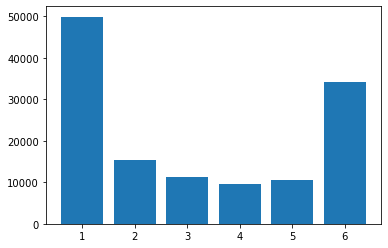

In [31]:
from ranky import rankz

obs = np.asarray(observation.to_array(), dtype=np.float32).squeeze();
obs_z500=obs[0,...].squeeze()
obs_t850=obs[1,...].squeeze()

pred=np.asarray(preds.to_array(), dtype=np.float32).squeeze();
pred_z500=pred[0,...].squeeze() 
pred_t850=pred[1,...].squeeze() 

mask=np.ones(obs_z500.shape) #useless
# feed into rankz function
result = rankz(obs_z500, pred_z500, mask)
# plot histogram
plt.bar(range(1,pred_z500.shape[0]+2), result[0])
# view histogram
plt.show() ##overconfident (underdispersive)